# Copula Demo

Before running, make sure the requirements have been installed correctly.

In [1]:
import json

from jax import random
import jax
import jax.numpy as jnp
import math
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC, MixedHMC, DiscreteHMCGibbs, SVI, Trace_ELBO, autoguide, Predictive
from numpyro.infer.reparam import TransformReparam
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import tqdm

import matplotlib.pyplot as plt

/Users/danielmanela/.virtualenvs/causal-copulas/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### What does `numpyro.sample` mean?
According to Numpyro's documentation, it simply returns a MC sample drawn from the input distribution. However, when contained within a Numpyro `model()` object which is passed to a Kernel, it also 

1. Defines the parameter in the posterior space
1. Adds the log-likelihood of the prior to the total log-posterior to be sampled.

Hence, these parameters can be defined by either a `sample()` based function, as below:

sample: 100%|█| 10500/10500 [00:04<00:00, 2138.36it/s, 1 steps of size 9.77e-01.


Mean: 0.010772526264190674. Var: 0.9858638644218445


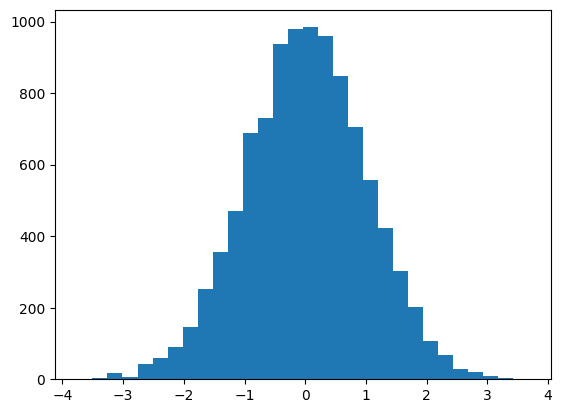

In [2]:
def sample_gaussian():
    # Need to initialise undefined variables with the `ImproperUniform()` object
    Z = numpyro.sample(
        'z', 
        dist.Normal(0, 1)
    )
    
sample_gaussian_kernel = NUTS(sample_gaussian)

sample_gaussian_mcmc = MCMC(
    sample_gaussian_kernel,
    num_warmup=500,
    num_samples=10000, 
    progress_bar=True
)
sample_gaussian_mcmc.run(random.PRNGKey(0))
plt.hist(np.array(sample_gaussian_mcmc.get_samples()['z']), bins=30);
print(f"Mean: {np.mean(sample_gaussian_mcmc.get_samples()['z'])}. Var: {np.var(sample_gaussian_mcmc.get_samples()['z'])}")

*Or* instead we can construct our log-posterior by simply adding the log-prior term using the `numpyro.factor()` command. This gives us the flexibility to use a variety of different functions and niche likelihoods that might not be found in the Numpyro Library. Below, we show how to sample from a Standard Gaussian using the factor approach. We still need to initialise the parameters we are sampling from, and can do so using wide Improper Uniform distributions (which assignes a value of 0 to every log-likelihood point in the space).

We see that both approaches sample from the same outcome!

sample: 100%|█| 10500/10500 [00:04<00:00, 2119.80it/s, 1 steps of size 9.77e-01.


Mean: 0.01068311557173729. Var: 0.9858933687210083


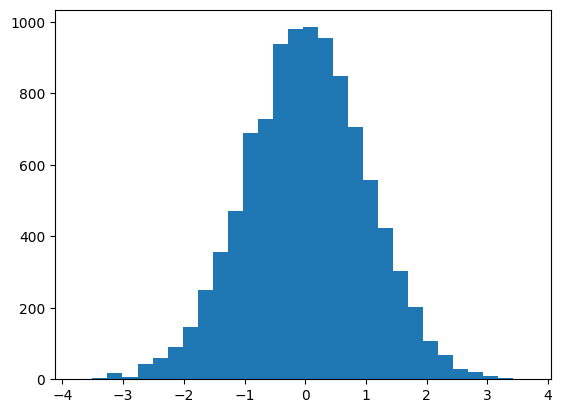

In [3]:
def std_gaussian(u):
    return -1 * jnp.square(u/jnp.sqrt(2))

def factor_gaussian():
    # Need to initialise undefined variables with the `ImproperUniform()` object
    Z = numpyro.sample(
        'z', 
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    numpyro.factor('gauss', std_gaussian(Z))
    
factor_gaussian_kernel = NUTS(factor_gaussian)

factor_gaussian_mcmc = MCMC(
    factor_gaussian_kernel,
    num_warmup=500,
    num_samples=10000, 
    progress_bar=True
)
factor_gaussian_mcmc.run(random.PRNGKey(0))
plt.hist(np.array(factor_gaussian_mcmc.get_samples()['z']), bins=30);
print(f"Mean: {np.mean(factor_gaussian_mcmc.get_samples()['z'])}. Var: {np.var(factor_gaussian_mcmc.get_samples()['z'])}")

## Didelez Model

We use the discrete/continuous model in Evans & Didelez as an example to illustrate our method.

In [4]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def base_didelez_model(y_dat=None, 
                       a_dat=None,
                       
                       a_const_sigmoid=0.,
                       alpha_0=0,
                       alpha_a=0,
                       gamma_0=0,
                       gamma_a=0,
                       gamma_l=0,
                       gamma_al=0,
                       beta_0=0,
                       beta_a=0,
                       beta_b=0,
                       beta_ab=0,
                       sigma_y=1):
    
    A = numpyro.sample("a", dist.Bernoulli(jax.nn.sigmoid(a_const_sigmoid)), sample_shape=())
    L_mu = numpyro.deterministic('l_mu', jnp.exp(-(alpha_0 + alpha_a * A)))
    L = numpyro.sample("l", dist.Exponential(L_mu), sample_shape=())
    quantiles_L = numpyro.deterministic('q_L', dist.Exponential(L_mu).cdf(L))
    
    B_prob = numpyro.deterministic(
        'b_prob', 
        jax.nn.sigmoid(
            gamma_0 + gamma_a * A + gamma_l * L + gamma_al * A * L
        )
    )
    B = numpyro.sample("b", dist.Bernoulli(B_prob), sample_shape=())    

    Y_mean = numpyro.deterministic('y_mean', beta_0 + beta_a * A + beta_b * B + beta_ab * A * B)
    Y = numpyro.sample("y", dist.Normal(Y_mean, sigma_y), sample_shape=())
    quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(Y_mean, sigma_y).cdf(Y))    
    
    # Choosing an arbitrary sigmoidal function for rho_ly
    # rho_LY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(0.6 * (B + A)))
    rho_LY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(1.))

    
    # `numpyro.factor()` appears to add a log-likelihood to the sampling space
    # If you want to add the renormalising factors, we can simply add or subtract
    # log-likelihood factors similar to what we do on the line below.
    std_normal_L = numpyro.deterministic('std_normal_l', dist.Normal(0, 1).icdf(quantiles_L))
    std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_L, std_normal_Y, rho_LY_val))

Since this model contains a mixture of discrete and continuous parameters, we must use a hybrid sampler to do so. Numpyro has two alternatives:

1. [`MixedHMC`](https://num.pyro.ai/en/stable/mcmc.html#id15)
1. [`DiscreteHMCGibbs()`](https://num.pyro.ai/en/stable/mcmc.html#id12)

When the likelihood contains a copula term whose off-diagnonal terms are functions of the other parameter (not simply constants), the `MixedHMC` approach took a great deal of time and would not finish. The second `DiscreteHMCGibbs` alternative uses a HMC/NUTS sampler for the continuous parameters and Gibbs sampler for the discrete ones. This one works far better and draws samples in a reasonable amount of time.

In [5]:
base_didelez_kernel = DiscreteHMCGibbs(NUTS(base_didelez_model), modified=True)

To remain consistent with the format in the `R` `causl` package, we constructed the parameterisation for the Didelez model in a similar form as the `R` vignettes.

In [6]:
params = {
    'A': {'a_const_sigmoid': 0.},
    'L': {'alpha_0': 0.3, 'alpha_a': 0.2},
    'B': {'gamma_0': -0.3, 'gamma_a': 0.4, 'gamma_l': 0.3, 'gamma_al': 0},
    'Y': {'beta_0': -0.5, 'beta_a': 0.2, 'beta_b': 0.3, 'beta_ab': 0}
}

print(params)

{'A': {'a_const_sigmoid': 0.0}, 'L': {'alpha_0': 0.3, 'alpha_a': 0.2}, 'B': {'gamma_0': -0.3, 'gamma_a': 0.4, 'gamma_l': 0.3, 'gamma_al': 0}, 'Y': {'beta_0': -0.5, 'beta_a': 0.2, 'beta_b': 0.3, 'beta_ab': 0}}


These are saved as a json format and can be loaded in R as a list using the `rjson` package:

In [7]:
R_params = {}
for k, v in params.items():
    R_params[k] = {'beta': list(v.values())}

with open('didelez_params.json', 'w') as file:
    json.dump(R_params, file)
print(R_params)

{'A': {'beta': [0.0]}, 'L': {'beta': [0.3, 0.2]}, 'B': {'beta': [-0.3, 0.4, 0.3, 0]}, 'Y': {'beta': [-0.5, 0.2, 0.3, 0]}}


### Running the model

In [8]:
%%time
mcmc_didelez = MCMC(
    base_didelez_kernel,
    num_warmup=1000,
    num_samples=1_000_000, 
    progress_bar=False
)

mcmc_didelez.run(
    random.PRNGKey(1),
    a_const_sigmoid=params['A']['a_const_sigmoid'],
    alpha_0=params['L']['alpha_0'],
    alpha_a=params['L']['alpha_a'],
    gamma_0=params['B']['gamma_0'],
    gamma_a=params['B']['gamma_a'],
    gamma_l=params['B']['gamma_l'],
    gamma_al=params['B']['gamma_al'],
    beta_0=params['Y']['beta_0'],
    beta_a=params['Y']['beta_a'],
    beta_b=params['Y']['beta_b'],
    beta_ab=params['Y']['beta_ab'],
    sigma_y=1
)
# mcmc_didelez.print_summary()  
didelez_samples = mcmc_didelez.get_samples()
mcmc_summary = pd.DataFrame(didelez_samples).describe().T
mcmc_summary

CPU times: user 11.2 s, sys: 153 ms, total: 11.4 s
Wall time: 11 s


,count,mean,std,min,25%,50%,75%,max
a,1000000.0,0.499980,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
b,1000000.0,0.578885,0.493738,0.000000,0.000000,1.000000,1.000000,1.000000
b_prob,1000000.0,0.578931,0.108135,0.425558,0.495049,0.561432,0.639119,0.999017
l,1000000.0,1.494859,1.509851,0.000005,0.425800,1.030961,2.065789,22.745905
l_mu,1000000.0,0.673677,0.067144,0.606531,0.606531,0.740818,0.740818,0.740818
q_L,1000000.0,0.499242,0.288644,0.000003,0.248930,0.499642,0.749019,0.999999
q_Y,1000000.0,0.499110,0.288657,0.000001,0.249291,0.498666,0.748655,0.999998
rho_ly,1000000.0,0.731058,0.000000,0.731059,0.731059,0.731059,0.731059,0.731059
std_normal_l,1000000.0,-0.003050,0.999917,-4.524683,-0.677861,-0.000898,0.671407,4.750758
std_normal_y,1000000.0,-0.002964,1.000844,-4.701596,-0.676723,-0.003344,0.670263,4.596739


#### Chains have mixed well

In [9]:
mcmc_didelez.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.50      0.50      0.00      0.00      1.00 5764107.26      1.00
         b      0.58      0.49      1.00      0.00      1.00 1902658.99      1.00
         l      1.49      1.51      1.03      0.00      3.44 294725.86      1.00
         y     -0.23      1.04     -0.23     -1.93      1.49 265312.62      1.00



### Saving the samlpes as a csv to be loaded into `R`

In [10]:
pd.DataFrame(didelez_samples).to_csv('didelez_samples_python.csv', index=False)

### Checking the copula is behaving sensibly

#### Quantiles for L and Y appear to be uniform
This gets thrown off a bit if the $\rho_{LY}$ parameter is very close to 1, but otherwise the quantiles appear uniform

In [ ]:
plt.hist(didelez_samples['q_L'], alpha=0.5);
plt.hist(didelez_samples['q_Y'], alpha=0.5);

#### Correlations observed for both the quantile plots

In [ ]:
plt.scatter(didelez_samples['q_L'], didelez_samples['q_Y'], alpha=0.2)

#### and also the raw gaussian copula

In [ ]:
plt.scatter(didelez_samples['std_normal_l'], didelez_samples['std_normal_y'], alpha=0.3)

#### whose Empirical Sufficient Statistics agree with the theoretical expectation

In [ ]:
np.mean(pd.DataFrame(didelez_samples)[['std_normal_l', 'std_normal_y']])

In [ ]:
np.cov(pd.DataFrame(didelez_samples)[['std_normal_l', 'std_normal_y']].T)

## Inference

Let us try to design a model that runs inference on this:

In [11]:
didelez_data = pd.DataFrame(didelez_samples)[1:1000000][['a', 'b', 'l', 'y']]

In [12]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def base_didelez_model_inference(y_obs=None, 
                                 a_obs=None,
                                 b_obs=None,
                                 l_obs=None,
                                 sigma_y=1):
    
    a_const_sigmoid = numpyro.sample('a_const_sigmoid',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    alpha_0 = numpyro.sample('alpha_0',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    alpha_a = numpyro.sample('alpha_a',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    gamma_0 = numpyro.sample('gamma_0',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    gamma_a = numpyro.sample('gamma_a',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    gamma_l = numpyro.sample('gamma_l',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )    
    gamma_al = numpyro.sample('gamma_al',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_0 = numpyro.sample('beta_0',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_a = numpyro.sample('beta_a',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_b = numpyro.sample('beta_b',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_ab = numpyro.sample('beta_ab',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    ) 
    
    A = numpyro.sample("a", dist.Bernoulli(jax.nn.sigmoid(a_const_sigmoid)), obs=a_obs)
    # L_mu = numpyro.deterministic('l_mu', jnp.exp(-(alpha_0 + alpha_a * A)))
    L_mu = jnp.exp(-(alpha_0 + alpha_a * A))
    L = numpyro.sample("l", dist.Exponential(L_mu), obs=l_obs)
    # quantiles_L = numpyro.deterministic('q_L', dist.Exponential(L_mu).cdf(L))
    quantiles_L = dist.Exponential(L_mu).cdf(L)
    
    # B_prob = numpyro.deterministic(
    #     'b_prob', 
    #     jax.nn.sigmoid(
    #         gamma_0 + gamma_a * A + gamma_l * L + gamma_al * A * L
    #     )
    # )
    B_prob = jax.nn.sigmoid(
        gamma_0 + gamma_a * A + gamma_l * L + gamma_al * A * L
    )    
    B = numpyro.sample("b", dist.Bernoulli(B_prob), obs=b_obs)    

    # Y_mean = numpyro.deterministic('y_mean', beta_0 + beta_a * A + beta_b * B + beta_ab * A * B)
    Y_mean = beta_0 + beta_a * A + beta_b * B + beta_ab * A * B
    Y = numpyro.sample("y", dist.Normal(Y_mean, sigma_y), obs=y_obs)
    # quantiles_Y = numpyro.deterministic('q_Y', dist.Normal(Y_mean, sigma_y).cdf(Y))   
    quantiles_Y = dist.Normal(Y_mean, sigma_y).cdf(Y)

    
    # Choosing an arbitrary sigmoidal function for rho_ly
    # rho_LY_val = numpyro.deterministic('rho_ly', jax.nn.sigmoid(0.6 * (B + A)))
    # rho_LY_val = jax.nn.sigmoid(0.6 * (B + A))
    rho_LY_val = numpyro.sample('rho_ly', dist.Beta(1, 1))
    
    # `numpyro.factor()` appears to add a log-likelihood to the sampling space
    # If you want to add the renormalising factors, we can simply add or subtract
    # log-likelihood factors similar to what we do on the line below.
    # std_normal_L = numpyro.deterministic('std_normal_l', dist.Normal(0, 1).icdf(quantiles_L))
    # std_normal_Y = numpyro.deterministic('std_normal_y', dist.Normal(0, 1).icdf(quantiles_Y))
    std_normal_L = dist.Normal(0, 1).icdf(quantiles_L)
    std_normal_Y = dist.Normal(0, 1).icdf(quantiles_Y)

    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_L, std_normal_Y, rho_LY_val))

In [ ]:
# didelez_kernel_inference = DiscreteHMCGibbs(NUTS(base_didelez_model_inference), modified=True)
didelez_kernel_inference = NUTS(base_didelez_model_inference)


mcmc_didelez_inference = MCMC(
    didelez_kernel_inference,
    num_warmup=500,
    num_samples=2000, 
    progress_bar=True
)

mcmc_didelez_inference.run(
    random.PRNGKey(1),
    a_obs=didelez_data[['a']].values,
    b_obs=didelez_data[['b']].values,
    l_obs=didelez_data[['l']].values,
    y_obs=didelez_data[['y']].values
)
mcmc_didelez_inference.print_summary()  
inferred_didelez_samples = mcmc_didelez_inference.get_samples()
summary_df = pd.DataFrame(numpyro.diagnostics.summary(mcmc_didelez_inference.get_samples(group_by_chain=True))).T
# pd.DataFrame(inferred_didelez_samples).describe()

In [ ]:
squashed_params = {}
for k_1, v_1 in params.items():
    for k_2, v_2 in v_1.items():
        squashed_params[k_2] = v_2 
params_df = pd.DataFrame.from_dict(squashed_params, orient='index', columns=['true_value'])
summary_df_analytics = summary_df.join(params_df)
summary_df_analytics['z_score'] = abs(summary_df_analytics['mean'] - summary_df_analytics['true_value']) / summary_df_analytics['std']

mcmc_params_df = summary_df_analytics[['mean']]
mcmc_params_df = mcmc_params_df.rename(columns={'mean': 'mean_MCMC'})
mcmc_params_df['mean_MCMC'] = mcmc_params_df['mean_MCMC'].round(2)

## Using Approx Inference

Numpyro doesn't seem to support approximate inference as well as Pyro. My guess is that the benefits of JAX serves the MCMC sampler using the autograd update. For standard VI, probably worth using Pyro instead as they have a lot more support for such methods.

In anycase, here is an example below:

In [ ]:
optimizer = numpyro.optim.Adam(step_size=0.005)

didelez_guide = autoguide.AutoDelta(base_didelez_model_inference)
svi = SVI(base_didelez_model_inference, guide=didelez_guide, optim=optimizer, loss=Trace_ELBO())

svi_result = svi.run(
    random.PRNGKey(0), 
    1000, 
    a_obs=didelez_data[['a']].values,
    b_obs=didelez_data[['b']].values,
    l_obs=didelez_data[['l']].values,
    y_obs=didelez_data[['y']].values
)

Can't find a way to generate an uncertainty estimate of outputs. All I can get are these parameters:

In [ ]:
svi_params = {k: round(float(v), 2) for k, v in svi_result.params.items()}
svi_params

In [ ]:
svi_params_df = pd.DataFrame.from_dict(svi_params, orient='index', columns=['mean_SVI'])
svi_params_df.index = svi_params_df.index.str[:-9]
svi_params_df

## Log Likelihood Optimisation

We initialise the parameters we are trying to infer randomly over a decent range. If we use a wider range sometimes the loss is incalculable (flips to nan) and so reasonable first guesses are required. Need to investigate further

In [13]:
true_params = {
    'a_const_sigmoid': 0.0,
    'alpha_0': 0.3,
    'alpha_a': 0.2,
    'gamma_0': -0.3,
    'gamma_a': 0.4,
    'gamma_l': 0.3,
    'gamma_al': 0.,
    'beta_0': -0.5,
    'beta_a': 0.2,
    'beta_b': 0.3,
    'beta_ab': 0.,
    'rho_ly': round(float(jax.nn.sigmoid(1.)), 2)
}
true_params_df = pd.DataFrame.from_dict(true_params, orient='index', columns=['True Params'])
np.random.seed(0)
starting_params = {k: np.random.uniform(-2., 2.) for k in true_params.keys()}
starting_params['rho_ly'] = np.random.uniform(0.1, 0.9)
starting_params

{'a_const_sigmoid': 0.195254015709299,
 'alpha_0': 0.8607574654896779,
 'alpha_a': 0.4110535042865755,
 'gamma_0': 0.17953273198758746,
 'gamma_a': -0.30538080264438117,
 'gamma_l': 0.5835764522666245,
 'gamma_al': -0.24965115494922996,
 'beta_0': 1.567092003128319,
 'beta_a': 1.8546510420041171,
 'beta_b': -0.4662339246968892,
 'beta_ab': 1.1669001523306584,
 'rho_ly': 0.5544356488751458}

In [14]:
def llhood(params, a_obs, b_obs, l_obs, y_obs):
    llhood = -1 * numpyro.infer.util.log_density(
        base_didelez_model_inference, 
        (),
        {
            "a_obs": a_obs,
            "b_obs": b_obs,
            "l_obs": l_obs,
            "y_obs": y_obs
        },
        params=params
    )[0]
    return llhood

def dllhood(params, a_obs, b_obs, l_obs, y_obs):
    return jax.grad(llhood)(params, a_obs, b_obs, l_obs, y_obs)

@jax.jit
def step(params, opt_state, a_obs, b_obs, l_obs, y_obs):
    loss = llhood(params, a_obs, b_obs, l_obs, y_obs)
    grads = dllhood(params, a_obs, b_obs, l_obs, y_obs)
    opt_state = opt_update(0, grads, opt_state)
    params = get_params(opt_state)
    return params, opt_state, loss

In [15]:
max_epochs = 100_000
batch_size = 1_000_000
losses = list()
sma_losses = list()
param_estimates = {k: [v] for k, v in starting_params.items()}
postfix = {}

opt_init, opt_update, get_params = jax.example_libraries.optimizers.adam(1e-2)
opt_state = opt_init(starting_params)
params = get_params(opt_state)


with tqdm.trange(max_epochs) as bar:
    for i in bar:
        shuffled_data = pd.DataFrame(didelez_samples).sample(frac = 1)            
        for n in range(math.ceil(shuffled_data.shape[0]/batch_size)):
            batch_df = shuffled_data[n:(n+batch_size)]
        # for i in tqdm.tqdm(range(max_epochs)):
            params, opt_state, value = step(
                params,
                opt_state,
                batch_df[['a']].values,
                batch_df[['b']].values,
                batch_df[['l']].values,
                batch_df[['y']].values
            )
            losses.append(round(float(value), 4))
            postfix = {}

            if len(losses) > 0:
                sma_losses.append(round(float(np.mean(losses[-50:])), 2))
                postfix["sma_Loss"] = f"{jnp.array(sma_losses[-1]):.4f}"                

            for ikey in params.keys():
                postfix[ikey] = f"{params[ikey]:.2f}"
                param_estimates[ikey].append(params[ikey])
            postfix["Loss"] = f"{jnp.array(losses[-1]):.4f}"

            # update progress bar
            if not n % 10:
                bar.set_postfix({'Loss': postfix['Loss'], 'SMA Loss': postfix['sma_Loss']})
            n_epochs = i + 1
                
        if (len(sma_losses) > 5):
            if (sma_losses[-1] == sma_losses[-2]):
                bar.set_postfix({'Convergence': 'True', 'Loss': postfix['Loss'], 'SMA Loss': postfix['sma_Loss']})
                break

  3%| | 3147/100000 [04:14<2:10:31, 12.37it/s, Convergence=True, Loss=4360784.00


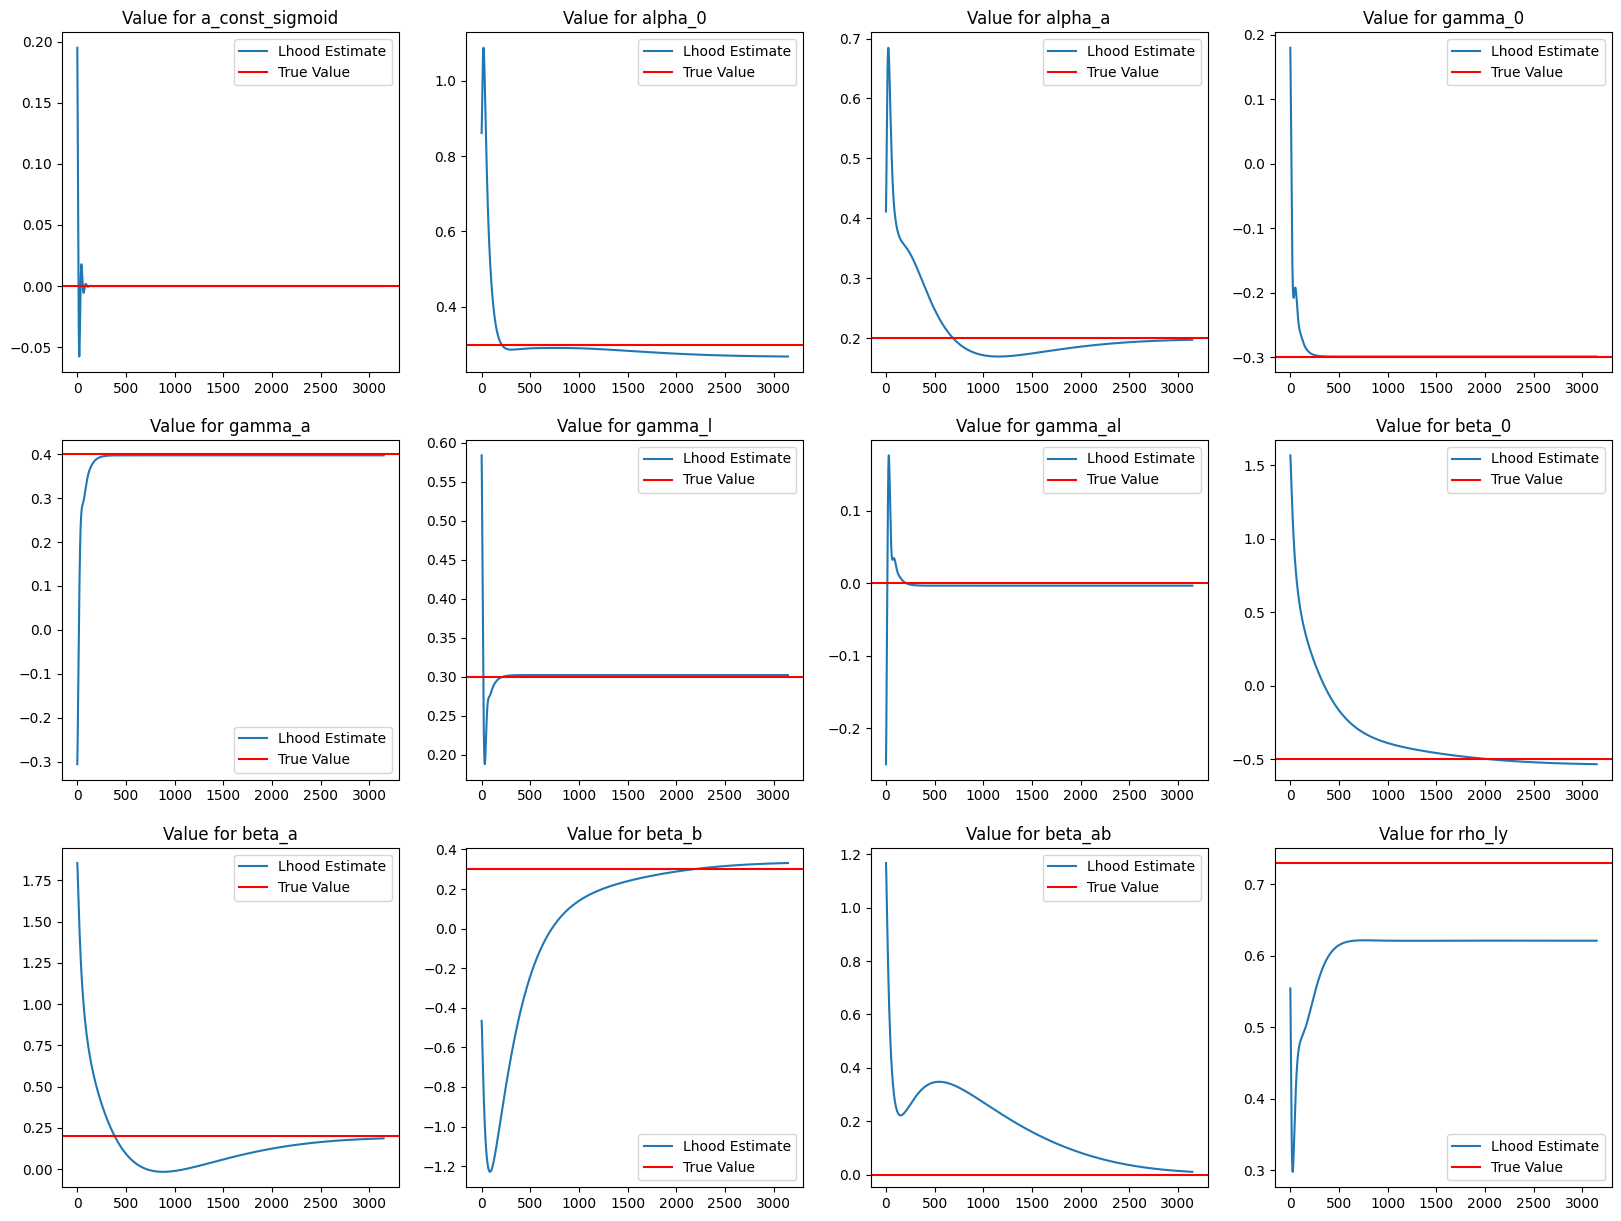

In [16]:
f, axs = plt.subplots(3, 4, figsize=(20, 15))

param_names = list(true_params.keys())
for i, ax in enumerate(f.axes):
    ax.plot(range(n_epochs+1), np.array(param_estimates[param_names[i]]), label='Lhood Estimate')
    ax.axhline(true_params[param_names[i]], color='r', label='True Value')
    # li.set_label('True Value')
    ax.title.set_text(f'Value for {param_names[i]}')
    ax.legend()

In [17]:
postfix = {k: round(float(v), 2) for k, v in postfix.items()}
llhood_params_df = pd.DataFrame.from_dict(postfix, orient='index', columns=['mean_llhood']).drop('Loss')

## Summary of results

#### Actual Values

In [ ]:
comparison_of_methods = true_params_df.join(mcmc_params_df).join(svi_params_df).join(llhood_params_df)
comparison_of_methods

#### Bias

In [ ]:
subset = comparison_of_methods.drop('True Params', axis=1).sub(comparison_of_methods['True Params'], axis=0)
subset